In [ ]:
#--------------------------------------------------------------------------------
# 1. Original code in `torch`/`torchvision`
#--------------------------------------------------------------------------------
# Credits-- this example is adapted and modified from pytorch's tutorial.


#----------------------------------------
# Dependencies.
#----------------------------------------

import torch
from torch.utils import data as tu_data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms.transforms as transforms

# --------------------------------------------------------------------------------
# Define the train and test transforms.
# --------------------------------------------------------------------------------

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.1,
                    contrast=0.1,
                    saturation=0.1,
                    hue=0.1,
                )
            ],
            p=0.5,
        ),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=3, sigma=[0.1, 2.0])], p=0.5
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# --------------------------------------------------------------------------------
# Define the dataloaders.
# --------------------------------------------------------------------------------

batch_size = 100

# Get the train loader.
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
trainloader = tu_data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Get the test loader.
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)
testloader = tu_data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# --------------------------------------------------------------------------------
# Define the model.
# --------------------------------------------------------------------------------

class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# --------------------------------------------------------------------------------
# Get the optimizer.
# --------------------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# --------------------------------------------------------------------------------
# Training phase.
# --------------------------------------------------------------------------------

NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        # Get the batch.
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Compute the loss, backprop the gradients, and update the parameters.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print running statistics.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # print every 200 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")

In [2]:
from PIL import ImageFilter
import numpy as np
import random

class PILRandomGaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image. Take the radius and probability of
    application as the parameter.
    This transform was used in SimCLR - https://arxiv.org/abs/2002.05709
    """

    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = np.random.rand() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )



def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

In [3]:
import parameterized_transforms.core as ptc


class ParameterFreeTransform(ptc.AtomicTransform):
    def __init__(
        self,
        tx_mode: ptc.TRANSFORM_MODE_TYPE = ptc.TransformMode.CASCADE,
    ) -> None:
        super().__init__(tx_mode=tx_mode)
        self.param_count = self.set_param_count()

    def set_param_count(self) -> int:
        return 0

    def get_raw_params(self, img: ptc.IMAGE_TYPE) -> ptc.PARAM_TYPE:
        return ()


    def post_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> ptc.PARAM_TYPE:
        return params

    def extract_params(
        self, params: ptc.PARAM_TYPE
    ) -> tuple[ptc.PARAM_TYPE, ptc.PARAM_TYPE]:
        return (), params

    def pre_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> ptc.PARAM_TYPE:
        return params

    def get_default_params(
        self, img: ptc.IMAGE_TYPE, processed: bool = True
    ) -> ptc.PARAM_TYPE:
        raw_id_params = ()
        return (
            self.post_process_params(img=img, params=raw_id_params)
            if processed
            else raw_id_params
        )

    def __str__(self) -> str:
        return (
            f"{self.__class__.__name__}("
            f"param_count={self.param_count}, "
            f"tx_mode={self.tx_mode}"
            f")"
        )
    
    
def make_parameter_free(cls):
    class Wrapper(ParameterFreeTransform):
        def __init__(self, *cls_args, tx_mode: ptc.TRANSFORM_MODE_TYPE = ptc.TransformMode.CASCADE, **cls_kwargs):
            super().__init__(tx_mode=tx_mode)
            self.transform = cls(*cls_args, **cls_kwargs)
            
        def apply_transform(self, img, params, **kwargs):
            return self.transform(img)
    
    return Wrapper



@make_parameter_free
class PILGaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image. Take the radius as the parameter.
    This transform was used in SimCLR - https://arxiv.org/abs/2002.05709
    """

    def __init__(self, radius_min=0.1, radius_max=2.):
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )

In [4]:
import parameterized_transforms.transforms as transforms
import parameterized_transforms.wrappers as wrappers
import parameterized_transforms.core as core
train_transform_pt = wrappers.CastParamsToTensor(
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(size=160, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [
                    transforms.ColorJitter(
                        brightness=0.8,
                        contrast=0.8,
                        saturation=0.8,
                        hue=0.2,
                        default_params_mode=core.DefaultParamsMode.RANDOMIZED,  # Extra subtle detail!
                    )
                ],
                p=0.5,
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply(
                # [make_parameter_free(PILGaussianBlur, 0.1, 2.0)()], p=0.5
                [PILGaussianBlur(0.1, 2.0)], p=0.5
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

In [5]:
from PIL import Image
img = Image.open("../../artifacts/img.jpg")

In [15]:
from torch import Tensor
from jaxtyping import Int, Float

def restore_coordinates(coords: Int[Tensor, "B 2"], params: Tensor, crop_size: int) -> Float[Tensor, "B 2"]:
    """
    Convert coordinates from the transformed image to the original image.
    
    Args:
        coords: Coordinates in the transformed image, shape (B, 2) as (y, x).
        params: A tensor containing at least 5 parameters [y, x, h, w, flip, ...].
        crop_size: The size of the crop (e.g., 160)
    
    Returns:
        A tensor of shape (B, 2) containing the coordinates in the original image.
    """
    # Ensure float type and correct device.
    params = params.float()
    coords = coords.float()

    # Extract the top-left corner and size of the crop.
    crop_origin = params[:2]      # [y, x] of the crop in the original image.
    crop_hw = params[2:4]         # [h, w] of the crop.
    flip = params[4]              # 0: no flip, 1: horizontal flip.

    # Define the offset: if flip is applied, adjust x coordinate accordingly.
    # Only x is affected by horizontal flip.
    flip_offset = torch.tensor([0.0, flip * crop_hw[1]], dtype=coords.dtype, device=coords.device)
    offset = crop_origin + flip_offset

    # Compute the sign: keep y as is and for x, flip if needed.
    sign = torch.tensor([1.0, 1.0], dtype=coords.dtype, device=coords.device)
    if flip.item() >= 0.5:
        sign[1] = -1.0

    # Scale coordinates from crop space to original crop dimensions.
    scaled = coords * (crop_hw / crop_size)

    # Apply flip (if any) and add the offset.
    restored = scaled * sign + offset
    return restored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.99215686].
/tmp/ipykernel_10152/1628706419.py:74: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[0].plot(orig_x, orig_y, 'ro', markersize=8, c='blue')
/tmp/ipykernel_10152/1628706419.py:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[1].plot(sample_point_x, sample_point_y, 'ro', markersize=8, c='blue')


160


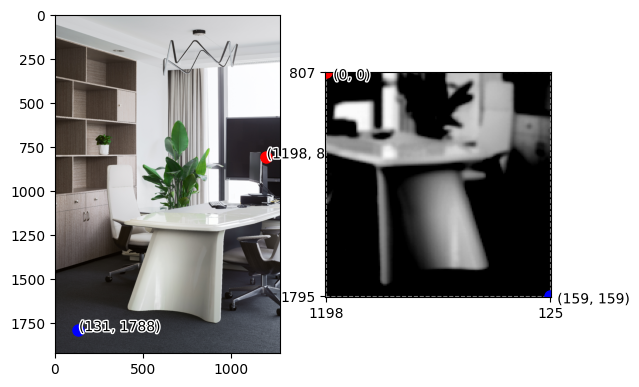

Horizontal flip: True


In [16]:
import numpy as np

def transformed_to_original_coords(transformed_y, transformed_x, params):
    """
    Convert coordinates from the transformed image to the original image.
    
    Args:
        transformed_y: y-coordinate in the transformed image (0 to 159).
        transformed_x: x-coordinate in the transformed image (0 to 159).
        params: Parameters returned by train_transform_pt [y, x, h, w, flip].
    
    Returns:
        Tuple (original_y, original_x) representing the coordinates in the original image.
    """
    y, x, h, w, flip = params[:5]
    
    # Scale from transformed image to original crop
    original_y = y + transformed_y * h / 160
    
    if flip:
        original_x = x + w - transformed_x * w / 160
    else:
        original_x = x + transformed_x * w / 160
    
    return original_y, original_x

# Show image with properly labeled coordinate grid
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

# Get the transformed image and parameters
t_img, params = train_transform_pt(img)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
# ax[1].imshow(t_img)
# t_img is tensor [3, 160, 160]
ax[1].imshow(np.transpose(t_img.numpy(), (1, 2, 0)))

# Extract the crop parameters
y, x, h, w = params[:4]
horizontal_flip = params[4]

# Set the ticks to show the original coordinates at the edges of the transformed image
ax[1].set_yticks([0, 159])
ax[1].set_yticklabels([int(y), int(y + h)])

N_TICKS = 3
if horizontal_flip:
    ax[1].set_xticks([0, 159])
    ax[1].set_xticklabels([int(x + w), int(x)])
else:
    ax[1].set_xticks([0, 159])
    ax[1].set_xticklabels([int(x), int(x + w)])

# Draw a grid
ax[1].grid(True, linestyle='--', alpha=0.7)

# Example: Mark a point in the transformed image and show its original coordinates
sample_point_y, sample_point_x = 0, 0
# orig_y, orig_x = transformed_to_original_coords(sample_point_y, sample_point_x, params)
crop_size = t_img.shape[-1]
print(crop_size)
orig_y, orig_x = restore_coordinates(Tensor([sample_point_y, sample_point_x]), params, crop_size)

ax[0].plot(orig_x, orig_y, 'ro', markersize=8)
ax[0].text(orig_x + 5, orig_y + 5, f'({int(orig_x)}, {int(orig_y)})', color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
ax[1].plot(sample_point_x, sample_point_y, 'ro', markersize=8)
ax[1].text(sample_point_x + 5, sample_point_y + 5, f'({int(sample_point_x)}, {int(sample_point_y)})', color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

sample_point_y, sample_point_x = 159, 159
# orig_y, orig_x = transformed_to_original_coords(sample_point_y, sample_point_x, params)
orig_y, orig_x = restore_coordinates(Tensor([sample_point_y, sample_point_x]), params, crop_size)

ax[0].plot(orig_x, orig_y, 'ro', markersize=8, c='blue')
ax[0].text(orig_x + 5, orig_y + 5, f'({int(orig_x)}, {int(orig_y)})', color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
ax[1].plot(sample_point_x, sample_point_y, 'ro', markersize=8, c='blue')
ax[1].text(sample_point_x + 5, sample_point_y + 5, f'({int(sample_point_x)}, {int(sample_point_y)})', color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

# plt.title('Transformed Image with Original Coordinate Grid')
plt.show()

print(f"Horizontal flip: {bool(horizontal_flip)}")


In [13]:
t_img.shape

torch.Size([3, 160, 160])

In [ ]:
#--------------------------------------------------------------------------------
# 2. New code in using `parameterized_transforms`
#--------------------------------------------------------------------------------


#----------------------------------------
# Dependencies.
#----------------------------------------

import torch
from torch.utils import data as tu_data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

# import torchvision.transforms.transforms as transforms
import parameterized_transforms.transforms as transforms
import parameterized_transforms.wrappers as wrappers
import parameterized_transforms.core as core

# --------------------------------------------------------------------------------
# Define the train and test transforms.
# --------------------------------------------------------------------------------

train_transform = wrappers.CastParamsToTensor(
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [
                    transforms.ColorJitter(
                        brightness=0.1,
                        contrast=0.1,
                        saturation=0.1,
                        hue=0.1,
                        default_params_mode=core.DefaultParamsMode.RANDOMIZED,  # Extra subtle detail!
                    )
                ],
                p=0.5,
            ),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomApply(
                [transforms.GaussianBlur(kernel_size=3, sigma=[0.1, 2.0])], p=0.5
            ),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)


test_transform = wrappers.CastParamsToTensor(
    transform=wrappers.ApplyDefaultParams(
        transform=transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [
                        transforms.ColorJitter(
                            brightness=0.1,
                            contrast=0.1,
                            saturation=0.1,
                            hue=0.1,
                            default_params_mode=core.DefaultParamsMode.RANDOMIZED,  # Extra subtle detail!
                        )
                    ],
                    p=0.5,
                ),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomApply(
                    [transforms.GaussianBlur(kernel_size=3, sigma=[0.1, 2.0])], p=0.5
                ),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
    )
)

# --------------------------------------------------------------------------------
# Define the dataloaders.
# --------------------------------------------------------------------------------

batch_size = 100

# Get the train loader.
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
trainloader = tu_data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Get the test loader.
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)
testloader = tu_data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# --------------------------------------------------------------------------------
# Define the model.
# --------------------------------------------------------------------------------

class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# --------------------------------------------------------------------------------
# Get the optimizer.
# --------------------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# --------------------------------------------------------------------------------
# Training phase.
# --------------------------------------------------------------------------------

NUM_EPOCHS = 2

for epoch in range(NUM_EPOCHS):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        # Get the batch.
        (inputs, params), labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Compute the loss, backprop the gradients, and update the parameters.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print running statistics.
        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # print every 200 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,   100] loss: 1.152
[1,   200] loss: 1.151
[1,   300] loss: 1.150
[1,   400] loss: 1.148
[1,   500] loss: 1.147
[2,   100] loss: 1.144
[2,   200] loss: 1.137
[2,   300] loss: 1.129
[2,   400] loss: 1.113
[2,   500] loss: 1.091
Finished Training


INFO | cat image dimensions: (width=1281, height=1920)
INFO | dog image dimensions: (width=500, height=375)


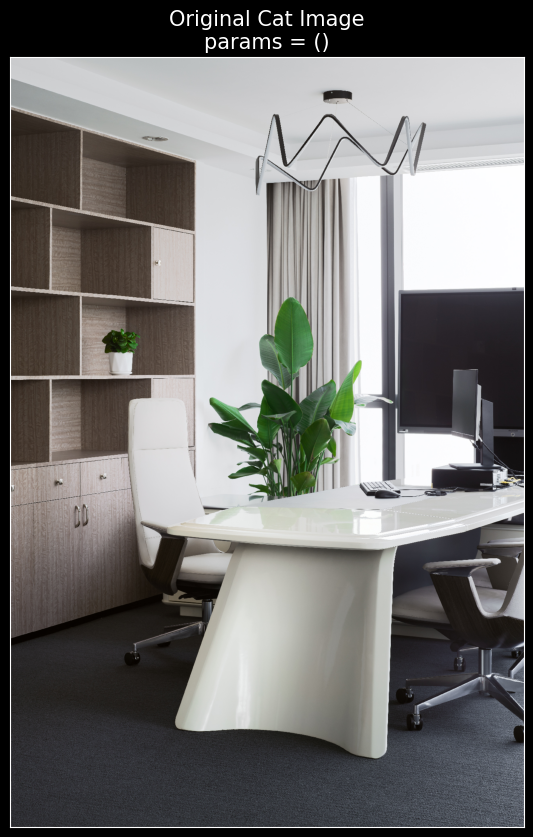

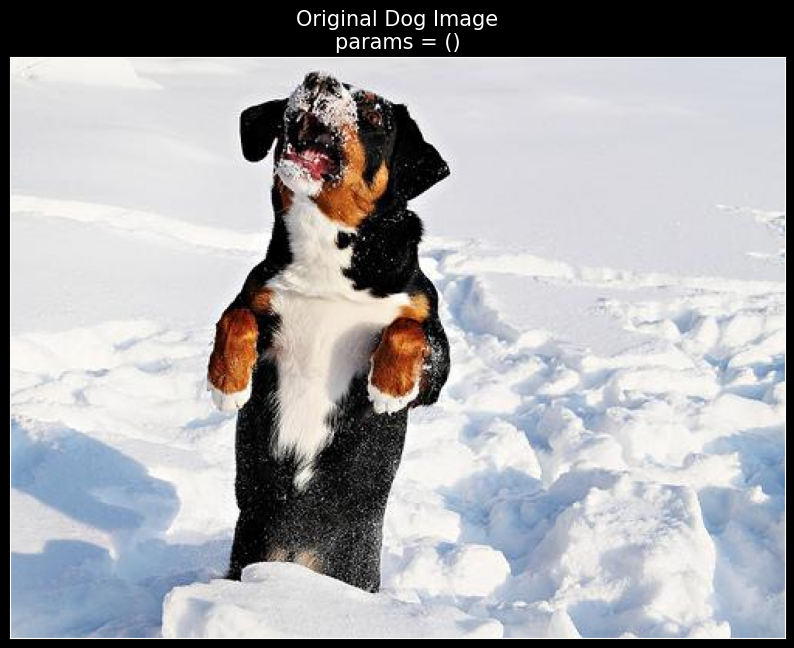

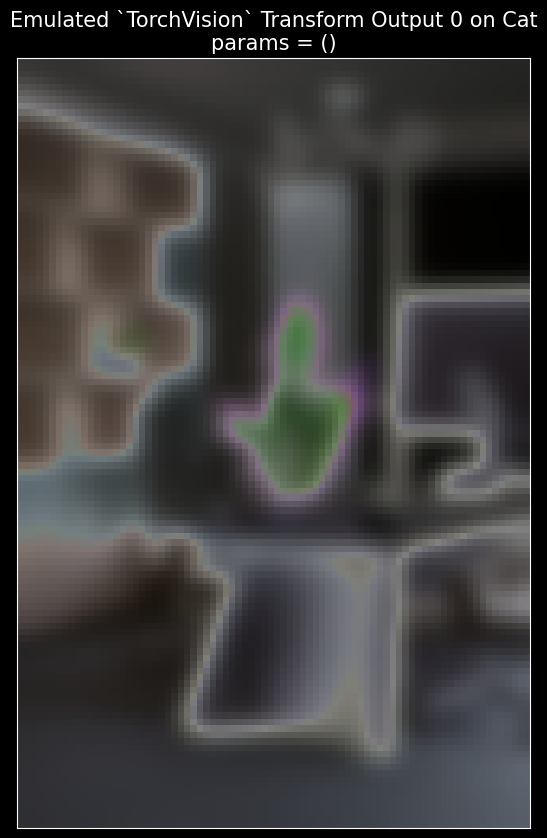

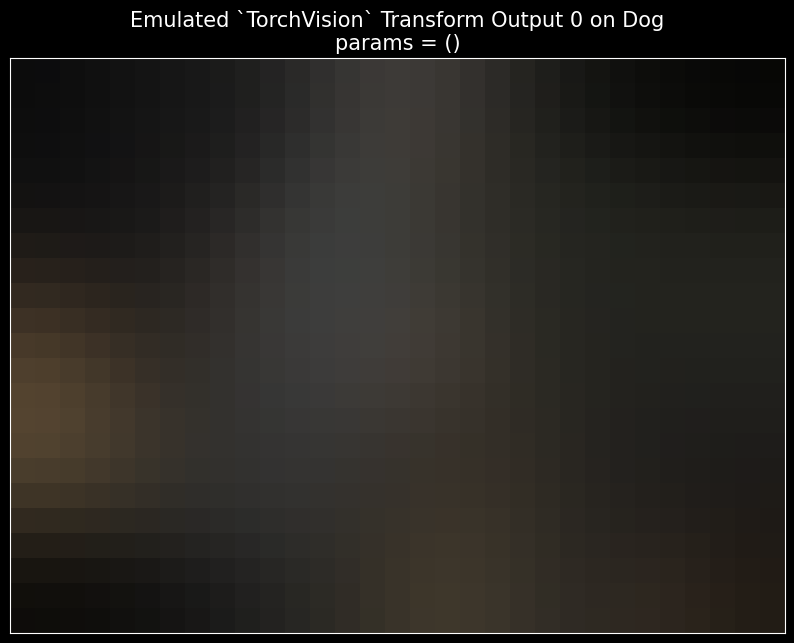

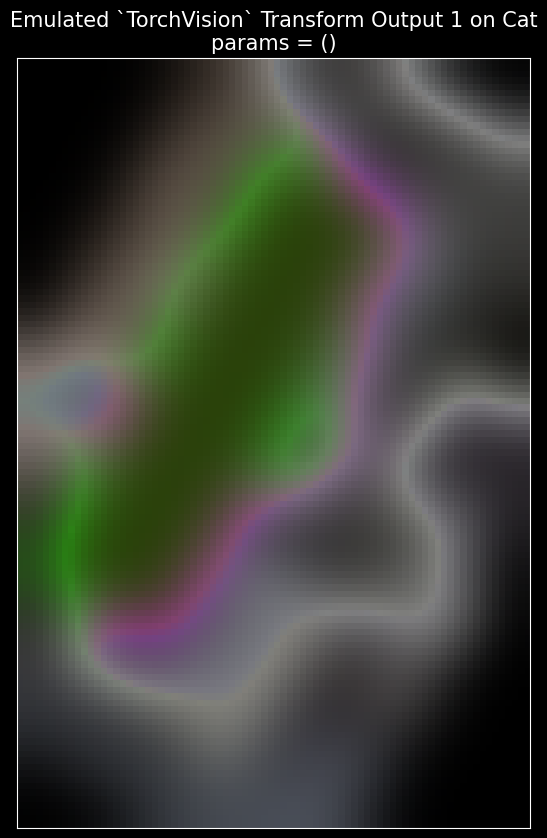

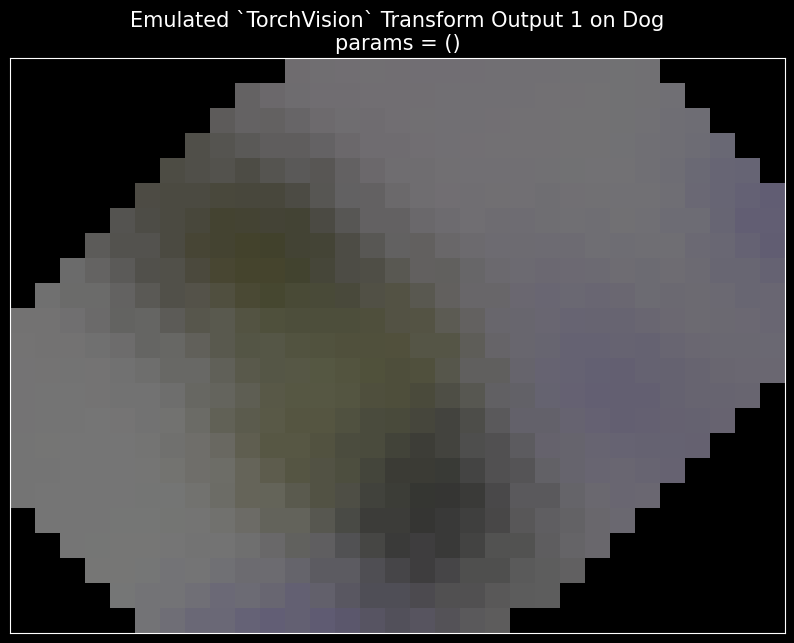

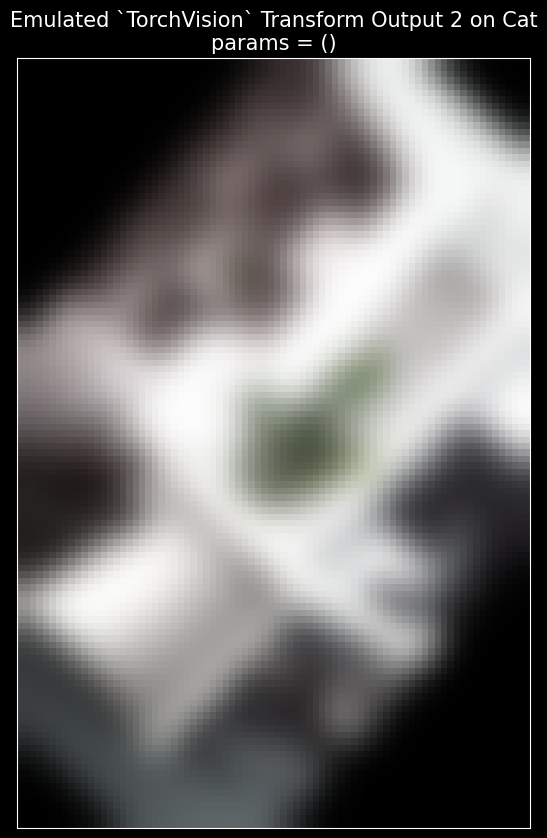

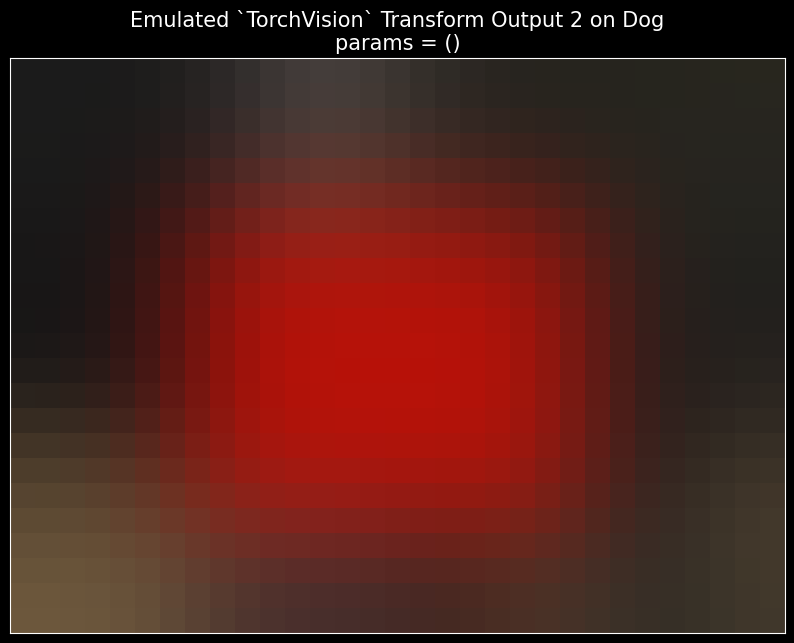

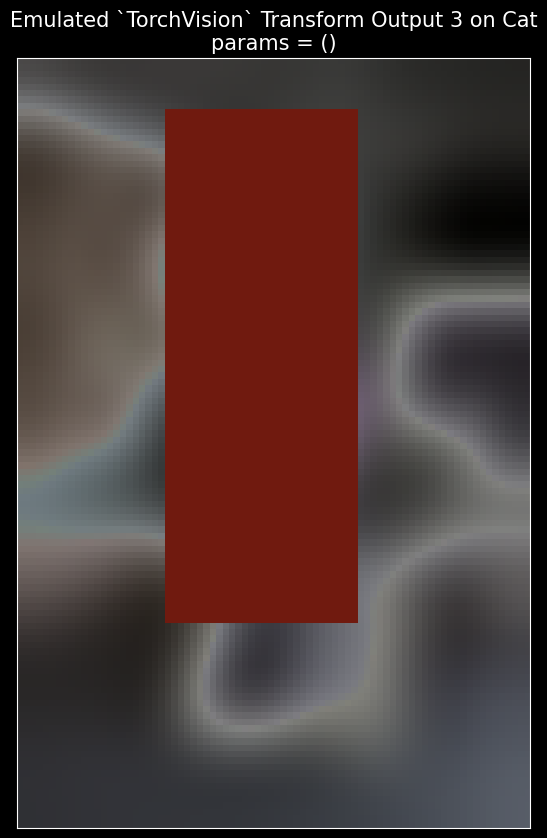

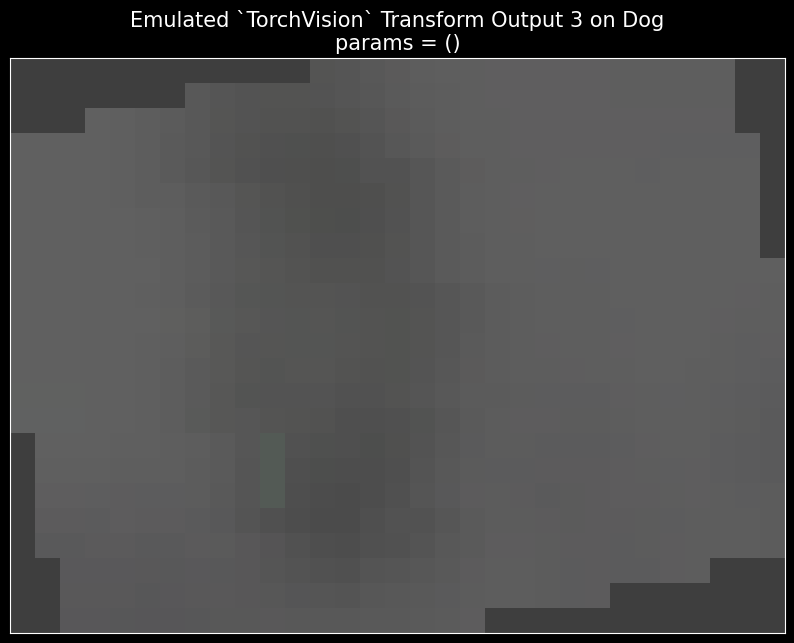

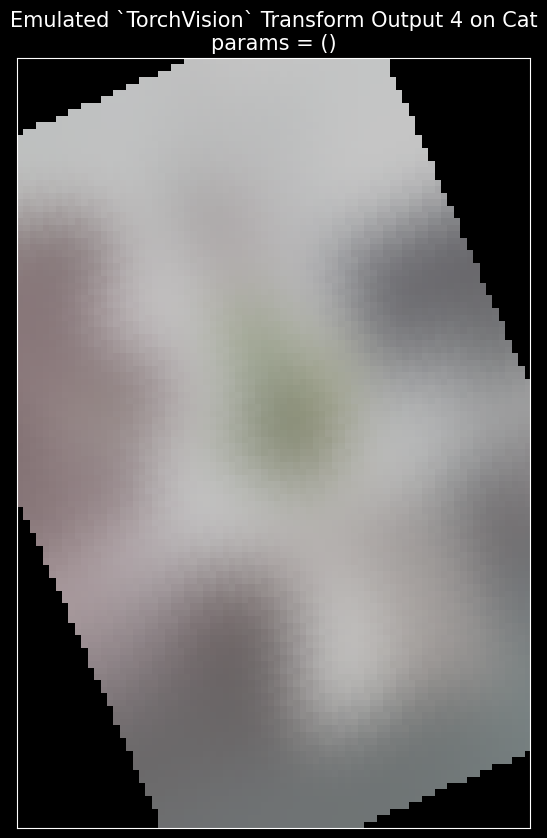

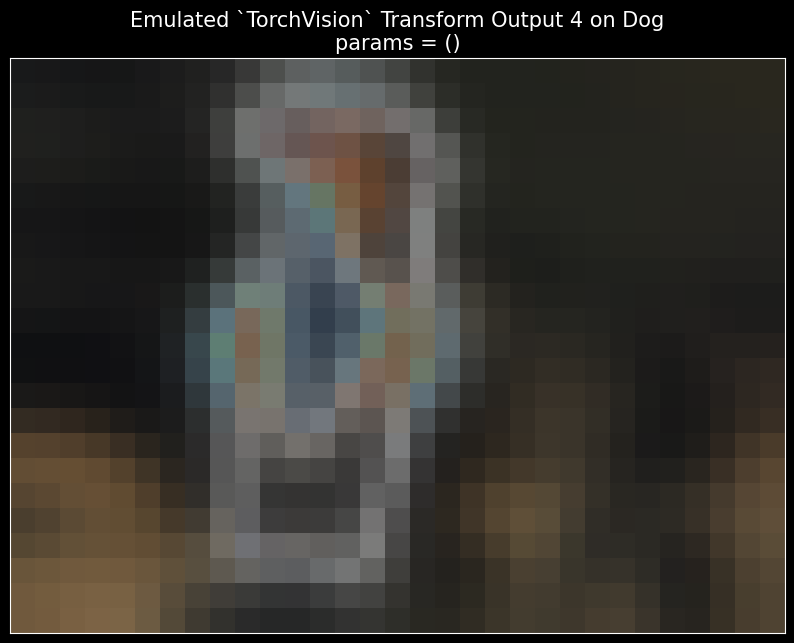

In [ ]:
#--------------------------------------------------------------------------------
# 3. Emulating `torchvision` with `parameterized_transforms`
#--------------------------------------------------------------------------------


# Dependencies.
import parameterized_transforms.core as ptc
import parameterized_transforms.transforms as ptx
import parameterized_transforms.utils as ptu
import parameterized_transforms.wrappers as ptw

import torchvision.transforms.functional as tv_fn

import numpy as np

import PIL.Image as Image
import PIL.ImageChops as ImageChops

import typing as t

import matplotlib.pyplot as plt
%matplotlib inline


def show_image(
    data: Image.Image, title: str, params: t.Any = (), save: bool = False,
) -> None:
    """Helper function to visualize the images.

    :param data: The image data of type `PIL.Image.Image`.
    :param title: The title of the image.
    :param params: The parameters for the image.
        DEFAULT: `()`.
    :param save: Whether to save the image.
        DEFAULT: `True`.
    """

    # Set figure style.
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(10, 10))

    # Process the data.
    data = np.asarray(data).astype(np.uint8)
    assert 0.0 <= np.min(data) <= np.max(data) <= 255.0

    # Clean the parameters.
    params = tuple(
        (int(elt) if elt == np.floor(elt) else round(elt, 2)) for elt in params
    )

    # Plot the image.
    plt.imshow(data)
    plt.title(f"{title}\nparams = {params}", fontdict={"size": 15})
    plt.xticks([])
    plt.yticks([])
    if save:
        plt.savefig(f"{title}.png")
    plt.show(block=False)


cat_img = Image.open("../../artifacts/img.jpg")
width, height = cat_img.size
print(f"INFO | cat image dimensions: (width={width}, height={height})")
dog_img = Image.open("../../artifacts/dog.jpg")
width, height = dog_img.size
print(f"INFO | dog image dimensions: (width={width}, height={height})")
# Show the images.
show_image(data=cat_img, title="Original Cat Image", params=())
show_image(data=dog_img, title="Original Dog Image", params=())
plt.close("all")


class RandomColorErasing(ptc.AtomicTransform):

    def __init__(
        self,
        tx_mode: ptc.TransformMode = ptc.TransformMode.CASCADE,
        default_params_mode: ptc.DefaultParamsMode = ptc.DefaultParamsMode.RANDOMIZED,
    ) -> None:
        """The initializer.

        :param tx_mode: The mode of the transform.
            DEFAULT: `ptc.TransformMode.CASCADE`.
            SUPPORTS: `ptc.TransformMode` enum type.
        :param default_params_mode: The mode of the default (identity) params.
            DEFAULT: `ptc.DefaultParamsMode.RANDOMIZED`.
            SUPPORTS: `ptc.DefaultParamsMode`.
        """

        super(RandomColorErasing, self).__init__()

        self.tx_mode = tx_mode  # Alternatively, pass tx_mode=tx_mode to the above super call.
        self.default_params_mode = default_params_mode

        self.param_count = self.set_param_count()  # Recommended.

    def set_param_count(self) -> int:
        """Returns the number of parameters for the transform.

        :return: The number of parameters.

        We encode the rectangle to be erased using 4 integers `i, j, h, w`.
        The tuple `(i, j)` encodes the top-left point of the crop
            (along the height and the width respectively).
        The integers `h, w` are the crop height and crop width.
        We encode the fill-color in terms of 3 integers in range `[0, 255]`
            representing the `R, G, B` components.

        Thus, in total, there are 7 parameters.
        """
        return 7

    def get_raw_params(self, img: ptc.IMAGE_TYPE) -> ptc.PARAM_TYPE:
        """Get raw parameters to decide which rectangle to erase and what
        should be the fill value.

        :param img: The input image.

        :return: The parameters for the rectangle to be erased and the fill value.
        """

        # Get a randomly sampled fill color.
        fill_color = np.random.randint(
            low=0, high=256, size=[3, ]
        ).astype(np.uint8)

        # Get the image dimensions.
        W, H = tv_fn.get_image_size(img=img)
        # Select two heights for the crop.
        i1, i2 = np.random.randint(low=0, high=H, size=[2, ]).tolist()
        j1, j2 = np.random.randint(low=0, high=W, size=[2, ]).tolist()
        # Get the location and size of the rectangle to be erased.
        i, h = min(i1, i2), max(abs(i2 - i1), 1)
        j, w = min(j1, j2), max(abs(j2 - j1), 1)

        # Return the tuple of raw parameters.
        return (i, j, h, w, fill_color)

    def apply_transform(
            self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE, **kwargs
    ) -> ptc.IMAGE_TYPE:
        """Augments given data point using given parameters.

        :param img: The data point to be augmented.
        :param params: The raw parameters to be used for augmentation.

        :return: The augmented image.
        """

        # Unpack the raw parameters.
        i, j, h, w, fill_color = params

        # Conver the `PIL` image to `numpy`.
        img_np = np.asarray(img).astype(np.uint8)
        # Replace the rectangular region with the sampled color.
        img_np[i: (i + h), j: (j + w), :] = fill_color

        # Convert this processed image back to a `PIL.image`
        aug = Image.fromarray(img_np)

        return aug

    def post_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> ptc.PARAM_TYPE:
        """Post-processes the parameters of augmentations before outputting.

        :param img: The data point to be augmented.
        :param params: The raw local parameters to be post-processed.

        :return: The post-processed parameters.
        """

        # Unpack all parameters into a tuple of scalars.
        i, j, h, w, fill_color = params
        r, g, b = fill_color.tolist()

        return (i, j, h, w, r, g, b)

    def extract_params(
        self, params: ptc.PARAM_TYPE
    ) -> t.Tuple[ptc.PARAM_TYPE, ptc.PARAM_TYPE]:
        """Chunks the input parameters into two sets; the first required for
        the augmentation of the current data and the second to pass on to the
        next augmentations.

        :param params: The parameters remaining from the augmentations so far.

        :return: The tuple of the local and subsequent parameters.
        """

        return params[: self.param_count], params[self.param_count :]

    def pre_process_params(self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE) -> ptc.PARAM_TYPE:
        """Pre-processes the parameters of augmentations after inputting.

        :param img: The data point to be augmented.
        :param params: The parameters from which to extract local parameters.

        :return: The pre-processed parameters ready for their usage.
        """

        # Unpack all parameters.
        i, j, h, w, r, g, b = params
        # Return the parameters as required for applying the transform.
        fill_color = np.array([r, g, b]).astype(np.uint8)

        # Return the raw parameters.
        return (i, j, h, w, fill_color)

    def get_default_params(self, img: ptc.IMAGE_TYPE, processed: bool = True) -> ptc.PARAM_TYPE:
        """Returns the parameters for preserving the input data information.

        :param img: The data point to be augmented.
        :param processed: Whether we want the processed default parameters.

        :return: The no-augmentation params for the class.
        """

        # If the default parameters are required to be unique, ...
        if self.default_params_mode == ptc.DefaultParamsMode.UNIQUE:

            # Define the rectangle to erase at the origin, with size 0.
            i, j, h, w = 0, 0, 0, 0
            # Define the fill color to be `(R, G, B) = (0, 0, 0)`.
            fill_color = np.zeros([3, ]).astype(np.uint8)

            raw_params = (i, j, h, w, fill_color)

        # Else, ...
        else:  # `self.default_params_mode == ptc.DefaultParamsMode.RANDOMIZED`

            # Select any point of the image as the rectangle location.
            W, H = tv_fn.get_image_size(img=img)
            i = int(np.random.randint(low=0, high=H))
            j = int(np.random.randint(low=0, high=W))
            # Set the size of the rectangle to 0.
            h, w = 0, 0

            # Select any fill color.
            fill_color = np.random.randint(
                low=0, high=256, size=[3, ]
            ).astype(np.uint8)

            raw_params = (i, j, h, w, fill_color)

        return (
            self.post_process_params(img=img, params=raw_params)
            if processed
            else raw_params
        )

    def __str__(self) -> str:
        """Defines the string representation of the transform.

        :return: The string representation of the transform.
        """
        return (
            f"RandomColorErasing("
            f"param_count={self.param_count}, "
            f"tx_mode={self.tx_mode}, "
            f"default_params_mode={self.default_params_mode}"
            f")"
        )


class RandomSubsetApply(ptc.ComposingTransform):

    def __init__(
        self,
        transforms: t.List[t.Callable],
        tx_mode: ptc.TransformMode,
    ) -> None:
        """The initializer.

        :param transforms: The list of transforms.
        :param tx_mode: The transform mode.
        """

        super(RandomSubsetApply, self).__init__()

        self.tx_mode = tx_mode
        self.transforms = transforms  # All composing transforms will have a core transform set/list/tuple.

        self.param_count = self.set_param_count()

        # Set the start and end indices of core transform parameters.
        self.idx_limits = [0]
        for tx in self.transforms:
            self.idx_limits.append(self.idx_limits[-1] + tx.param_count)
        # Set the number of core transforms.
        self.num_core_transforms = len(self.transforms)

    def set_param_count(self) -> int:
        """Returns the total number of processed parameters generated by the
        transform under consideration.

        :return: The number of parameters for this transform.
        """

        # The total number of parameters is just addition of those of the components.
        return ptu.get_total_params_count(transforms=self.transforms)


    def get_raw_params(self, img: ptc.IMAGE_TYPE) -> ptc.PARAM_TYPE:
        """Generates the raw parameters used to augment current data point.

        :param img: The data point to be augmented.

        :return: Current raw parameters to augment the data point.
        """

        # Decide which transforms to apply and which to skip as 1's and 0's.
        return tuple(
            np.random.randint(low=0, high=2, size=[self.num_core_transforms])
        )

    def apply_cascade_transform(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE, **kwargs
    ) -> ptc.TRANSFORM_RETURN_TYPE:
        """Augments given data point using given parameters.

        :param img: The data point to be augmented.
        :param params: The parameters to be used for augmentation.

        :return: The augmented image and corresponding augmentation parameters.
        """

        # Collect the augmentation params from the core transforms.
        aug_params = ()

        for apply, tx in zip(params, self.transforms):

            # If we have to apply the transform, apply and collect parameters.
            if apply:
                img, tx_params = tx(img=img, params=())
            # Else, get default parameters and apply them on the image.
            else:
                tx_params = tx.get_default_params(img=img, processed=True)
                img, rem_tx_params = tx.consume_transform(img=img, params=tx_params)
                assert rem_tx_params == ()  # Safety check!

            # Either way, collect the parameters.
            aug_params += tx_params

        # Return the final augmented image and the corresponding parameters.
        return img, aug_params

    def post_process_params(
        self,
        img: ptc.IMAGE_TYPE,
        params: ptc.PARAM_TYPE,
        aug_params: ptc.PARAM_TYPE
    ) -> t.Tuple[ptc.PARAM_TYPE, ptc.PARAM_TYPE]:
        """Post-processes the parameters of augmentations before outputting.

        :param img: The data point to be augmented.
        :param params: The raw local parameters to be post-processed.
        :param aug_params: The processed params from the composition of transforms.

        :return: The post-processed parameters.
        """

        # We ignore the local parameters describing which transforms to apply.
        return (), aug_params

    def extract_params(
        self, params: ptc.PARAM_TYPE
    ) -> t.Tuple[ptc.PARAM_TYPE, ptc.PARAM_TYPE]:
        """Chunks the input parameters into two sets; the first required for
        the augmentation of the current data and the second to pass on to the
        next augmentations.

        :param params: The parameters remaining from the augmentations so far.

        :return: The tuple of the local and subsequent parameters.
        """

        return params[: self.param_count], params[self.param_count :]

    def pre_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> t.Tuple[ptc.PARAM_TYPE, ptc.PARAM_TYPE]:
        """Pre-processes the parameters of augmentations after inputting.

        :param img: The data point to be augmented.
        :param params: The parameters from which to extract local parameters.

        :return: The pre-processed parameters ready for their usage.
        """

        # We do NOT need local params, the aug params contain all information.
        return (), params

    def apply_consume_transform(
        self,
        img: ptc.IMAGE_TYPE,
        params: ptc.PARAM_TYPE,
        aug_params: ptc.PARAM_TYPE
    ) -> ptc.TRANSFORM_RETURN_TYPE:
        """Applies the transform with given parameters by consuming them.

        :param img: The data point to be augmented.
        :param params: The parameters remaining from the augmentations so far.
        :param aug_params: The parameters from composition of transforms.

        :return: The augmented image with the remaining parameters.
        """

        # We ignore the local params and only chunk and apply aug_params.
        for idx, tx in enumerate(self.transforms):

            # Extract the parameters for the current transform.
            tx_params = aug_params[
                self.idx_limits[idx]:self.idx_limits[idx + 1]
            ]
            # Apply these params to the image.
            img, rem_tx_params = tx.consume_transform(img=img, params=tx_params)
            assert rem_tx_params == ()  # Safety check!

        # Return the transformed image and the remaining parameters.
        return img, ()

    def get_default_params(
        self, img: ptc.IMAGE_TYPE, processed: bool = True
    ) -> ptc.PARAM_TYPE:
        """Returns the parameters for preserving the input data information.

        :param img: The data point to be augmented.
        :param processed: Whether we want the processed default parameters.

        :return: The no-augmentation params for the class.
        """

        # Get local params.
        local_params = (0 for _ in range(self.num_core_transforms))  # No transform to apply.

        # Collect the core default parameters.
        core_default_params = ()

        # Get core default parameters and keep on applying.
        for tx in self.transforms:

            # Get the default parameters of the core transform.
            default_tx_params = tx.get_default_params(img=img, processed=processed)
            # Append the parameters to core default parameters.
            core_default_params += default_tx_params

            # To make default parameters from the next transforms consistent, apply these default parameters too.
            img, rem_tx_params = tx.consume_transform(img=img, params=default_tx_params)
            assert rem_tx_params == ()  # Safety check!

        return (
            self.concat_params(
                *(self.post_process_params(img=img, params=local_params, aug_params=core_default_params))
            )
            if processed
            else local_params + core_default_params
        )

    def __str__(self) -> str:
        """Defines the string representation of the transform.

        :return: The string representation of the transform.
        """

        # Set the start and end strings.
        start_string, end_string = "RandomSubsetApply(", ")"

        # Set the local details of the `RandomSubsetApply` transform.
        details_string = ptu.indent(
            data = (
                f"param_count={self.param_count},\n"
                f"tx_mode={self.tx_mode}, "
            ), indentor="  ", connector="\n"
        )

        # Get the cleaned string representation of the core transforms.
        core_start_string, core_end_string = "transforms=(", ")"

        core_tx_strings = []
        for tx in self.transforms:
            core_tx_strings.append(
                ptu.indent(data=str(tx), indentor="  ", connector="\n")
            )
        core_tx_string = ptu.indent(data=",\n".join(core_tx_strings), indentor="  ", connector="\n")
        core_combined_string = ptu.indent(
            data="\n".join([core_start_string, core_tx_string, core_end_string]),
            indentor="  ",
            connector="\n"
        )

        return "\n".join([start_string, details_string, core_combined_string, end_string])


class ParamNormRandomColorErasing(RandomColorErasing):

    def __init__(
        self,
        tx_mode: ptc.TransformMode = ptc.TransformMode.CASCADE,
        default_params_mode: ptc.DefaultParamsMode = ptc.DefaultParamsMode.RANDOMIZED,
    ) -> None:
        """The initializer.

        :param tx_mode: The mode of the transform.
            DEFAULT: `ptc.TransformMode.CASCADE`.
            SUPPORTS: `ptc.TransformMode` enum type.
        :param default_params_mode: The mode of the default (identity) params.
            DEFAULT: `ptc.DefaultParamsMode.RANDOMIZED`.
            SUPPORTS: `ptc.DefaultParamsMode`.
        """

        super(ParamNormRandomColorErasing, self).__init__(
            tx_mode=tx_mode, default_params_mode=default_params_mode
        )

        # # Since the number of parameters is going to remain the same, we do NOT need to explicitly re-define it.
        # # In case the number of parameters changed, we MUST re-define it.
        # self.param_count = self.set_param_count()  # Your implementation of `set_param_count`

    def post_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> ptc.PARAM_TYPE:
        """Post-processes the parameters of augmentations before outputting.
        Here, the post-processing normalizes the parameters.

        :param img: The data point to be augmented.
        :param params: The raw local parameters to be post-processed.

        :return: The post-processed parameters.

        Note that the normalization scheme provided here keeps ALL possible
        default parameters in the range `[0, 1]`.
        """

        # Get the processed parameters from `super`.
        i, j, h, w, r, g, b = super(
            ParamNormRandomColorErasing, self
        ).post_process_params(img=img, params=params)

        # Normalize the crop location and size by image size.
        W, H = img.size
        norm_i, norm_j, norm_h, norm_w = \
            i / H, j / W, h / H, w / W

        # Normalize the colors.
        norm_r, norm_g, norm_b = r / 255., g / 255., b / 255.

        # Return the normalized parameters.
        return (norm_i, norm_j, norm_h, norm_w, norm_r, norm_g, norm_b)

    def pre_process_params(
        self, img: ptc.IMAGE_TYPE, params: ptc.PARAM_TYPE
    ) -> ptc.PARAM_TYPE:
        """Pre-processes the parameters of augmentations after inputting.
        Here, the pre-processing un-normalizes the normalized parameters.

        :param img: The data point to be augmented.
        :param params: The parameters from which to extract local parameters.

        :return: The pre-processed parameters ready for their usage.
        """

        norm_i, norm_j, norm_h, norm_w, norm_r, norm_g, norm_b = params

        # Get the image size.
        W, H = img.size

        # Unnormalize the crop location and size.
        i, j, h, w = \
            int(round(norm_i * H)), \
            int(round(norm_j * W)), \
            int(round(norm_h * H)), \
            int(round(norm_w * W))

        # Unnormalize the colors.
        r, g, b = \
            int(round(norm_r * 255.)), \
            int(round(norm_g * 255.)), \
            int(round(norm_b * 255.))

        # Return the pre-processed output of the `super`.
        return super(
            ParamNormRandomColorErasing, self
        ).pre_process_params(img=img, params=(i, j, h, w, r, g, b))


# Let us take the same example transform.
parameterized_tx = ptx.RandomOrder(
    transforms=[
        # The first component is the `RandomSubsetApply` as seen in previous examples!
        RandomSubsetApply(
            transforms=[
                ParamNormRandomColorErasing(
                    tx_mode=ptc.TransformMode.CASCADE,
                    default_params_mode=ptc.DefaultParamsMode.RANDOMIZED
                ),
                ptx.RandomRotation(degrees=45)
            ],
            tx_mode=ptc.TransformMode.CASCADE,
        ),
        # The second component is the random choice-- either solarize or apply color-jitter!
        ptx.RandomChoice(
            transforms=[
                ptx.RandomSolarize(threshold=127, p=1.0),  # always solarize!
                ptx.ColorJitter(
                    brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2
                )
            ],
            tx_mode=ptc.TransformMode.CASCADE,
        ),
        # The third component is an application of two different gaussian blurs!
        ptx.Compose(
            transforms=[
                ptx.GaussianBlur(kernel_size=21, sigma=[0.1, 2.0]),
                ptx.GaussianBlur(kernel_size=21, sigma=[0.1, 5.0])
            ]
        )
    ],
    tx_mode=ptc.TransformMode.CASCADE,
    default_params_mode=ptc.DefaultParamsMode.RANDOMIZED,
)

emulated_torchvision_tx = ptw.DropParams(parameterized_tx)

# Reduce the image size for a faster output!
# Original works too but you need to wait for a long time to see outputs! :)
cat_img_small = cat_img.resize([int(dim / 16) for dim in cat_img.size])
dog_img_small = dog_img.resize([int(dim / 16) for dim in dog_img.size])

for idx_ in range(5):
    aug_cat_small = emulated_torchvision_tx(cat_img_small)
    aug_dog_small = emulated_torchvision_tx(dog_img_small)
    assert isinstance(aug_cat_small, Image.Image)
    assert isinstance(aug_dog_small, Image.Image)
    show_image(data=aug_cat_small, title=f"Emulated `TorchVision` Transform Output {idx_} on Cat", params=(), save=False)
    show_image(data=aug_dog_small, title=f"Emulated `TorchVision` Transform Output {idx_} on Dog", params=(), save=False)

plt.close("all")